Notebook from kaggle by Ayushman Buragohain

In [1]:
import sys
sys.path.append('../input/timmmodels/pytorch-image-models')

!git clone https://github.com/benihime91/leaf-disease-classification-kaggle.git
!wandb login a74f67fd5fae293e301ea8b6710ee0241f595a63
!pip install torch-summary

Cloning into 'leaf-disease-classification-kaggle'...
remote: Enumerating objects: 316, done.
remote: Counting objects: 100% (316/316), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 693 (delta 197), reused 198 (delta 88), pack-reused 377
Receiving objects: 100% (693/693), 10.83 MiB | 16.25 MiB/s, done.
Resolving deltas: 100% (400/400), done.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
import os
import wandb
import albumentations as A

from fastai.vision.all import *
from fastai.callback.wandb import *
from fastai.callback.cutmix import *
from torchsummary import summary

import logging
logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)

## Functions

For the sake of simplicity, we will borrow from `timm` lib and `cassava_utils` script

In [3]:
import timm
from cassava_utils import *

In [4]:
SEED        = 42
IDX         = generate_random_id()
OOF_FOLD    = 0
NUM_CLASSES = 5
CSV_PATH    = './leaf-disease-classification-kaggle/data/fold_df.csv'
IMAGE_DIR   = '../input/cassava-leaf-disease-classification/train_images/'
INPUT_DIMS  = 224
MODEL       = 'tf_efficientnet_b3_ns'
PROJECT     = 'kaggle-leaf-disease-fastai-runs'
SAVE_NAME   = f"{MODEL}-fold={OOF_FOLD}-{IDX}"

set_seed(SEED, reproducible=True)

Ts = [MODEL, 'ranger', 'label-smoothing', 'mish', str(INPUT_DIMS)]
Ns = f'{MODEL} + Mish + Ranger + LabelSmoothing'
run = wandb.init(project=PROJECT, tags=Ts, notes=Ns,)

wandb: Currently logged in as: ayushman (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Dataset

Our dataset today will be the data from kaggle's [Cassava Leaf Disease Classification](https://www.kaggle.com/c/cassava-leaf-disease-classification).

Goal : using pretrained models , see how well of accuracy we can get in x epochs for the OOF validation dataset.

Pretrained models are loaded mainly from the `timm` library.

In [5]:
data = get_dataset(CSV_PATH, IMAGE_DIR, OOF_FOLD, shuffle=True)
data.head()

,image_id,label,filePath,kfold,is_valid
0,1587173996.jpg,Healthy,../input/cassava-leaf-disease-classification/train_images/1587173996.jpg,2,False
1,404115232.jpg,Cassava Mosaic Disease (CMD),../input/cassava-leaf-disease-classification/train_images/404115232.jpg,0,True
2,3945098769.jpg,Cassava Mosaic Disease (CMD),../input/cassava-leaf-disease-classification/train_images/3945098769.jpg,1,False
3,4037735151.jpg,Cassava Mosaic Disease (CMD),../input/cassava-leaf-disease-classification/train_images/4037735151.jpg,3,False
4,730805822.jpg,Cassava Mosaic Disease (CMD),../input/cassava-leaf-disease-classification/train_images/730805822.jpg,1,False


In [10]:
TRAIN_AUGS = A.Compose([
    A.OneOf([A.RandomResizedCrop(INPUT_DIMS, INPUT_DIMS), A.CenterCrop(INPUT_DIMS, INPUT_DIMS)], p=0.5),
    A.Resize(INPUT_DIMS, INPUT_DIMS, p=1.0),
    A.OneOf([A.HorizontalFlip(), A.Rotate(60)]),
    A.OneOf([A.Flip(),A.IAAPerspective(), A.ShiftScaleRotate(),], p=0.5),
    A.RandomBrightnessContrast(0.1, 0.1, p=0.5),
    A.OneOf([A.CLAHE(), A.HueSaturationValue(0.2, 0.2, 0.2, p=0.4),], p=0.5),
    A.CoarseDropout(p=0.5),
    A.Cutout(p=0.5),])

VALID_AUGS = A.Compose([A.Resize(INPUT_DIMS, INPUT_DIMS, p=1.0)])

ITEM_TFMS  = AlbumentationsTransform(TRAIN_AUGS, VALID_AUGS)
BATCH_TFMS = [Normalize.from_stats(*imagenet_stats)]

n_gpus = num_distrib() or 1

dls = get_dataloaders(data, ITEM_TFMS, BATCH_TFMS, workers=min(8, num_cpus()//n_gpus), bs=64)

For pretrained models we will working out of Ross Wightman's. Included in this repository is tons of pretrained models for almost every major model in Computer Vision.

## Efficientnet_b3_ns + Mish + Ranger + LabelSmoothing

The function below loads a custom model from the `timm` library using the name of the model and prepares it for transfer via fastai `Learner`.

In [12]:
#straight copy from - github: https://github.com/lessw2020/Ranger-Mish-ImageWoof-5/blob/master/mxresnet.py
class Mish(nn.Module):
    'Mish activation'
    def __init__(self)  : super().__init__()
    def forward(self, x): return x *( torch.tanh(F.softplus(x)))

#modified from - https://stackoverflow.com/questions/58297197/how-to-change-activation-layer-in-pytorch-pretrained-module
def all_mish(model):
    'recursively replace all ReLU/SiLU activations to Mish activation'
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU) or isinstance(child,nn.SiLU):
            setattr(model, child_name, Mish())
        else:
            all_mish(child)

In [13]:
@delegates(Learner)
def timm_learner(dls,m_name:str, cut:int, c:int, state:str=None, init:bool=True,
                 pretrained:bool=True, act:callable=nn.ReLU(inplace=True), modifier=None,**kwargs):
    'create a fast.ai learner instance from timm'
    encoder = timm.create_model(m_name, pretrained=pretrained, )
    
    model   = TransferLearningModel(encoder, num_classes=c, cut=cut, act=act, init=init)
    
    if modifier is not None: modifier(model)
    if state is not None   : model.load_state_dict(torch.load(state)) 
    
    learn = Learner(dls, model, **kwargs)
    return learn

In [14]:
learn = timm_learner(dls, MODEL, cut=-2, c=dls.c, pretrained=True, act=Mish(),
                    init=True, metrics=[accuracy], splitter=custom_splitter, modifier=all_mish,
                    wd=1e-2, opt_func=ranger, loss_func=LabelSmoothingCrossEntropy(), 
                    cbs=[WandbCallback(seed=SEED, log_preds=False, log_model=False)]).to_native_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b3_ns-9d44bf68.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b3_ns-9d44bf68.pth


In [15]:
_ = summary(learn.model, (3, INPUT_DIMS, INPUT_DIMS), device='cpu')

Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 1536, 7, 7]          --
|    └─Conv2dSame: 2-1                             [-1, 40, 112, 112]        1,080
|    └─BatchNorm2d: 2-2                            [-1, 40, 112, 112]        80
|    └─Mish: 2-3                                   [-1, 40, 112, 112]        --
|    └─Sequential: 2-4                             [-1, 384, 7, 7]           --
|    |    └─Sequential: 3-1                        [-1, 24, 112, 112]        3,504
|    |    └─Sequential: 3-2                        [-1, 32, 56, 56]          48,118
|    |    └─Sequential: 3-3                        [-1, 48, 28, 28]          110,912
|    |    └─Sequential: 3-4                        [-1, 96, 14, 14]          638,700
|    |    └─Sequential: 3-5                        [-1, 136, 14, 14]         1,387,760
|    |    └─Sequential: 3-6                        [-1, 232, 7, 7]           4,628,964
|

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.004365158267319202)

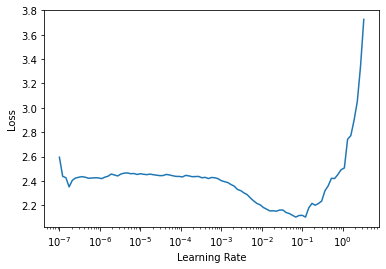

In [16]:
learn.lr_find()

In [17]:
learn.fit_flat_cos(10, slice(1e-02), pct_start=0.7)

epoch,train_loss,valid_loss,accuracy,time
0,0.947092,0.853577,0.796028,05:38
1,0.816370,0.800395,0.823598,05:00
2,0.850591,0.780293,0.827336,04:59
3,0.824068,0.761201,0.821729,05:04
4,0.805457,0.738514,0.843458,05:18
5,0.799299,0.709583,0.848598,05:11
6,0.763927,0.719269,0.850234,05:14
7,0.724669,0.703138,0.857477,05:10
8,0.691796,0.684299,0.865654,05:09
9,0.668048,0.680671,0.866822,05:11


In [18]:
learn.save('stage-1')

Path('models/stage-1.pth')

In [22]:
learn = learn.load('stage-1')

SuggestedLRs(lr_min=9.999999747378752e-07, lr_steep=1.5848931980144698e-06)

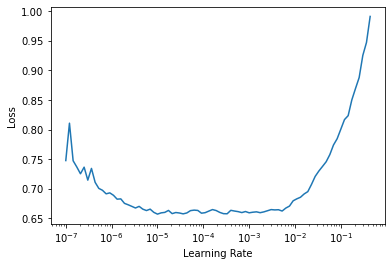

In [20]:
learn.lr_find()

In [23]:
learn.fit_flat_cos(10, slice(1e-03), pct_start=0)

epoch,train_loss,valid_loss,accuracy,time
0,0.656719,0.678470,0.872430,05:10
1,0.659276,0.677730,0.869626,05:12
2,0.654847,0.674199,0.873131,05:14
3,0.641166,0.679219,0.873365,05:10
4,0.644939,0.680618,0.873365,05:11
5,0.629088,0.687923,0.874299,05:20
6,0.633810,0.681805,0.876402,05:21
7,0.626303,0.686239,0.873598,05:28
8,0.635666,0.690068,0.874299,05:36
9,0.628396,0.692447,0.873365,05:36


In [24]:
learn.save('stage-2')

Path('models/stage-2.pth')

Let's upload the models weights to `wandb`

In [25]:
learn = learn.load('stage-2')
learn.unfreeze()
learn = learn.to_native_fp32()

In [26]:
save_dir = f"/kaggle/working/{SAVE_NAME}.pt"
torch.save(learn.model.state_dict(), save_dir)
wandb.save(save_dir)
wandb.finish()

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


epoch,23
train_loss,0.6284
raw_loss,0.80449
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,0.0
beta_0,0.0
wd_1,0.01
sqr_mom_1,0.99


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▃▃▄▃▂▄▅▅▃▂▄▃▃▂▂▂▁▃▃▂▂▄▂▃▂▁▂▂▂▁▂▂▁▂▁▃▂▂▂
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,█████████████▇▅▃▂▄▄▄▄▄▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
